# Trees!

In [42]:
library(dplyr)
library(caret)
library(rpart)
library(rpart.plot)
library(rattle)
library(RColorBrewer)
library(randomForest)


randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:rattle’:

    importance

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
titanic <- read.csv('../../data/titanic/clean.csv') %>%
mutate(Age = as.integer(Age))

In [4]:
head(titanic, 5)

Age,Fare,Parch,PassengerId,Pclass,SibSp,Family.Members,Cabin_A10,Cabin_A11,Cabin_A14,⋯,Embarked_C,Embarked_NaN,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass.category_1,Pclass.category_2,Pclass.category_3,Survived
24,69.3000,0,642,1,0,0,0,0,0,⋯,1,0,0,0,1,0,1,0,0,1
40,46.9000,6,1031,3,1,7,0,0,0,⋯,0,0,0,1,0,1,0,0,1,0
28,7.8542,0,282,3,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,1,0
62,80.0000,0,830,1,0,0,0,0,0,⋯,0,1,0,0,1,0,1,0,0,1
29,22.0250,1,1286,3,3,4,0,0,0,⋯,0,0,0,1,0,1,0,0,1,0


In [5]:
str(titanic)

'data.frame':	1309 obs. of  204 variables:
 $ Age                  : int  24 40 28 62 29 32 34 45 71 48 ...
 $ Fare                 : num  69.3 46.9 7.85 80 22.02 ...
 $ Parch                : num  0 6 0 0 1 0 0 0 0 2 ...
 $ PassengerId          : num  642 1031 282 830 1286 ...
 $ Pclass               : num  1 3 3 1 3 3 3 2 1 2 ...
 $ SibSp                : num  0 1 0 0 3 0 0 0 0 0 ...
 $ Family.Members       : num  0 7 0 0 4 0 0 0 0 2 ...
 $ Cabin_A10            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A11            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A14            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A16            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A18            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A19            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A20            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A21            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A23            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cabin_A24            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cab

In [6]:
set.seed(10)

train_ind <- sample(nrow(titanic), round(nrow(titanic) * 0.9))
train <- titanic[train_ind,]
test <- titanic[-train_ind, ]

head(train, 6)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Family.Members,Cabin_A10,Cabin_A11,Cabin_A14,⋯,Embarked_C,Embarked_NaN,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass.category_1,Pclass.category_2,Pclass.category_3,Survived
665,63,26.0000,0,905,2,1,1,0,0,0,⋯,0,0,0,1,0,1,0,1,0,0
402,4,39.0000,1,619,2,2,3,0,0,0,⋯,0,0,0,1,1,0,0,1,0,1
558,18,7.7500,0,776,3,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,1,0
906,50,211.5000,1,1110,1,1,2,0,0,0,⋯,1,0,0,0,1,0,1,0,0,1
112,45,26.5500,0,537,1,0,0,0,0,0,⋯,0,0,0,1,0,1,1,0,0,0
294,5,31.3875,2,234,3,4,6,0,0,0,⋯,0,0,0,1,1,0,0,0,1,1


# The Simplest Decision Tree


### Deterministic:

Let's suppose people in the age bracket 22 - 25 are the [strongest](https://www.swimmingworldmagazine.com/news/age-analysis-of-rio-swimming-finalists-the-older-the-better/) swimmers, so let's take the mean and build a model which predicts everyone over 23.5 will die, and everyone under 23.5 will survive:

In [7]:
our_guess <- test %>%
select(Age, Survived) %>%
mutate(prediction = ifelse(Age > 23.5, 0, 1),
      correct_prediction = ifelse(prediction == Survived, 1, 0))

head(our_guess, 5)

Age,Survived,prediction,correct_prediction
62,1,0,0
49,0,0,1
30,0,0,1
35,1,0,0
29,1,0,0


In [8]:
correct_perc = round(mean(our_guess$correct_prediction), 4)*100
print(paste("We were correct", correct_perc, "% of the time"))

[1] "We were correct 53.44 % of the time"


In [11]:
cm <- confusionMatrix(data = as.factor(our_guess$prediction), 
                      reference = as.factor(our_guess$Survived))

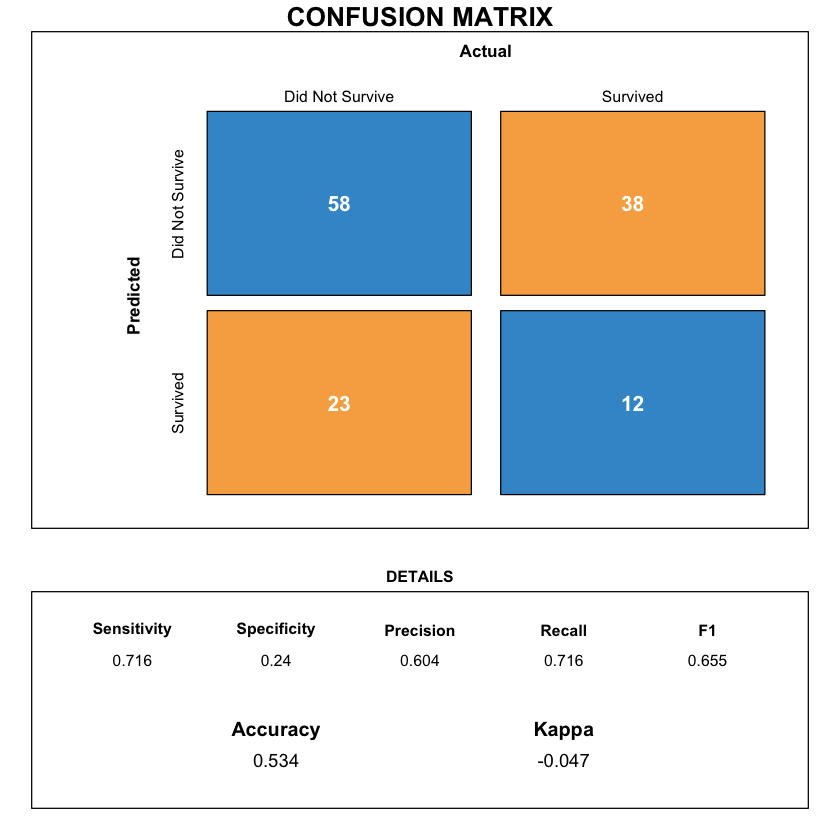

In [12]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Did Not Survive', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Survived', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Did Not Survive', cex=1.2, srt=90)
  text(140, 335, 'Survived', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  

draw_confusion_matrix(cm)

# Multifactor Decision Tree

In reality, we want to use many available features to make a decision.

Start with largest partition, then next, then next.

Can be prone to overfitting (lot of splits)

In [48]:
fit_tree <- rpart(Survived ~ Age + Fare + Pclass + Family.Members + Sex_female,
               data=train,
               method="class")


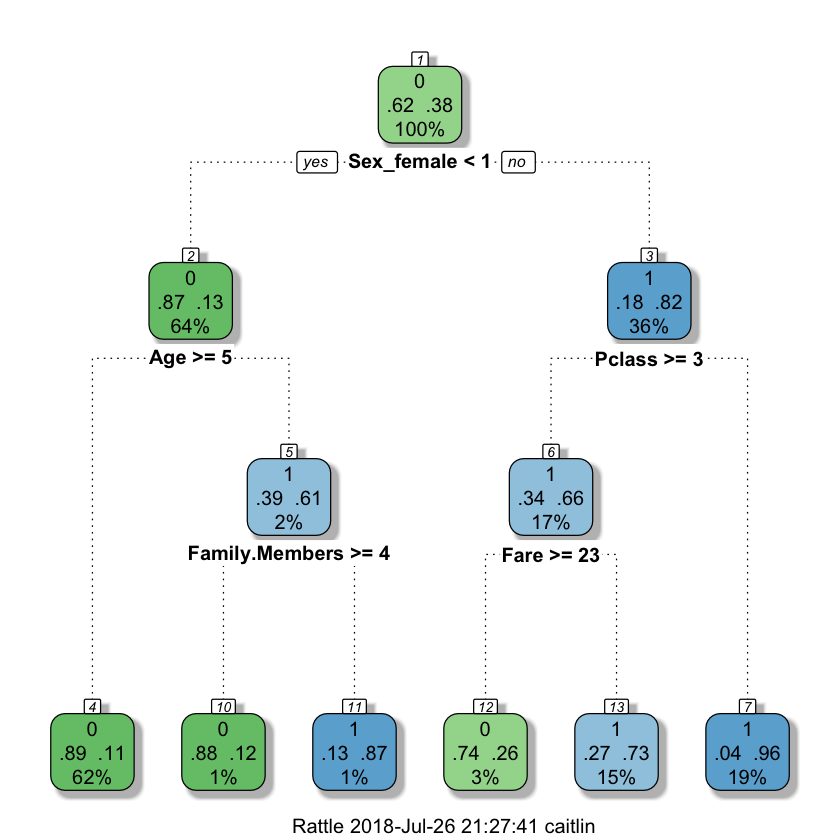

In [49]:
fancyRpartPlot(fit_tree)

In [50]:
predictions <- predict(fit_tree, test, type = "class")

test_predictions <- data.frame(passenger = test$PassengerId, survived = test$Survived, predicted = predictions) %>%
mutate(correct_prediction = ifelse(survived == predicted, 1, 0))

head(test_predictions, 5)

passenger,survived,predicted,correct_prediction
830,1,1,1
974,0,0,1
1170,0,0,1
259,1,1,1
741,1,0,0


In [51]:
correct_tree = round(mean(test_predictions$correct_prediction), 4)*100
print(paste("We were correct", correct_tree, "% of the time"))

[1] "We were correct 86.26 % of the time"


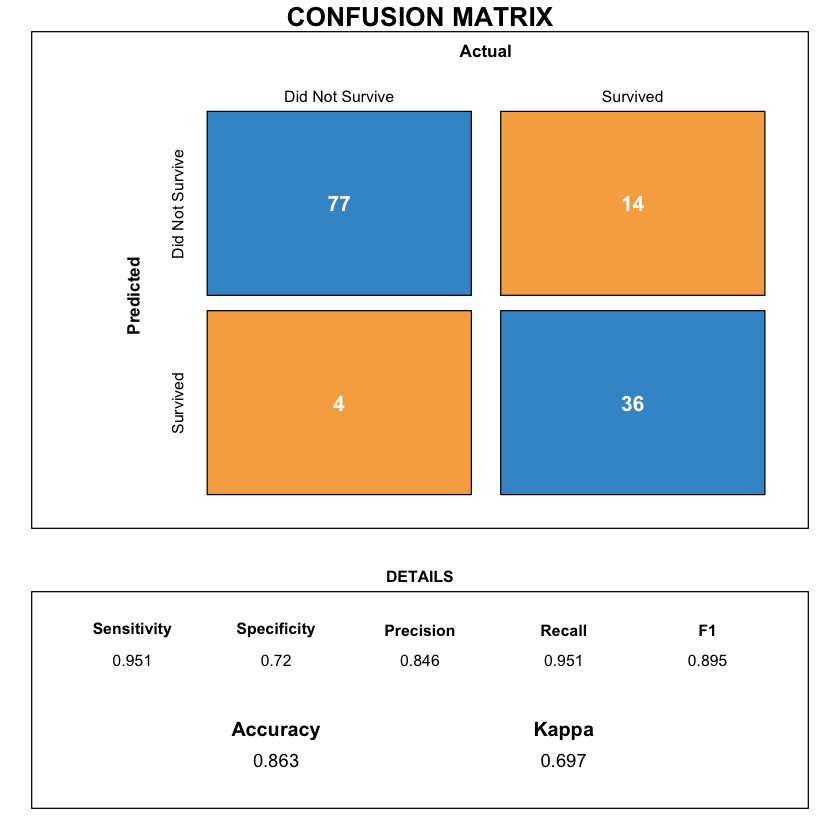

In [52]:
cm2 <- confusionMatrix(data = as.factor(test_predictions$predicted), 
                      reference = as.factor(test_predictions$survived))

draw_confusion_matrix(cm2)

# Random Forest


* Nonlinear; robust to over-fitting
* Hyperparameters tuned manually
* Start by generating lots of individual decision trees
    * A single tree isn't very accurate, but lots of trees combined produce accurate models


In [59]:
rf_fit <- randomForest(as.factor(Survived) ~ Age + Fare + Pclass + Family.Members + Sex_female,
                      data=train, 
                      importance=TRUE, 
                      ntree=500)

In [60]:
rf_predict <- predict(rf_fit, test)

rf_test_predictions <- data.frame(passenger = test$PassengerId, survived = test$Survived, predicted = rf_predict) %>%
mutate(correct_prediction = ifelse(survived == predicted, 1, 0))

head(rf_test_predictions, 5)

passenger,survived,predicted,correct_prediction
830,1,1,1
974,0,0,1
1170,0,0,1
259,1,1,1
741,1,0,0


In [61]:
correct_rf = round(mean(rf_test_predictions$correct_prediction), 4)*100
print(paste("We were correct", correct_rf, "% of the time"))

[1] "We were correct 87.02 % of the time"


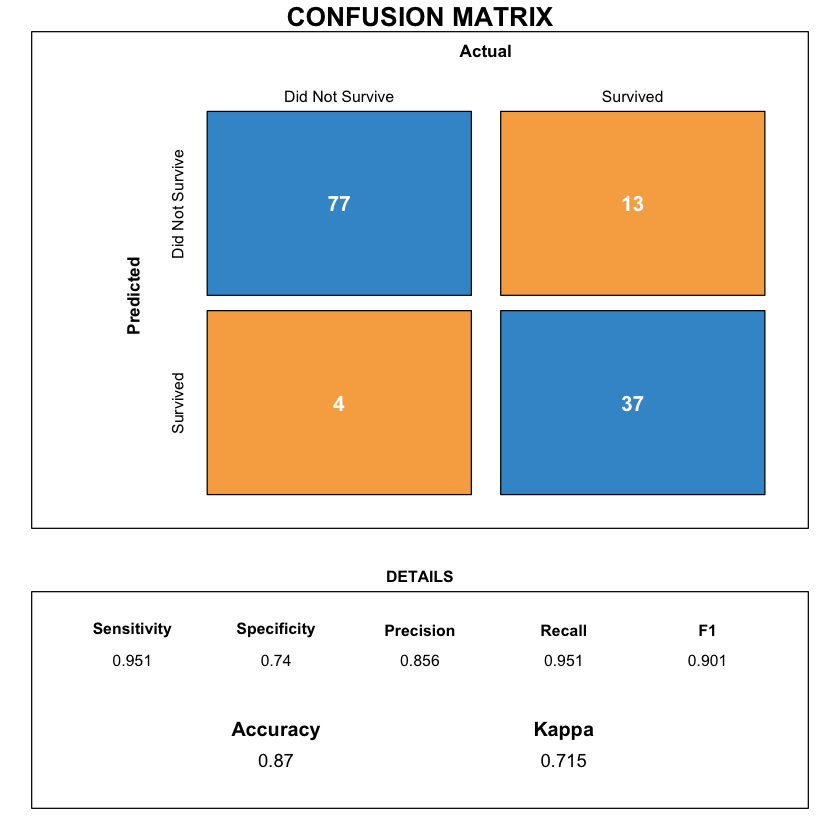

In [62]:
cm3 <- confusionMatrix(data = as.factor(rf_test_predictions$predicted), 
                      reference = as.factor(rf_test_predictions$survived))

draw_confusion_matrix(cm3)